# Diffusion for 256 x 256

In [3]:
import jupyter_black

import sys, os, shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from PIL import Image

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [4]:
# Custom modules
from dataset import ImageDataset, create_substrate_dataset, get_part_substrates_from_all
from unet import UNet
from diffusion import Diffusion
from utils_diffusion import (
    train,
    count_fid_metric,
    show_grid_samples,
    generate_and_save_samples,
)

In [9]:
# Dirs
sample_dir = "/usr/src/samples_substrate"
substrate_dir = "/usr/src/data/substrates"
part_substrate_dir = "/usr/src/data/part_substrates"
part_substrate_old_dir = "/usr/src/data/part_substrates_old"

image_size = 256

In [10]:
# Settings
channels = 1
batch_size = 15
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the dataset of substrates
substrate_dataset = create_substrate_dataset(part_substrate_dir)

# Create the dataloader for training
train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Old dataset of substrates
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)

substrate_dataset = ImageDataset(part_substrate_old_dir, "part_substrate", transform)
train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Check dataset and trainloader

print(f"Len of dataset:  {len(substrate_dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  7503 images
Len of trainloader:  501 batches
Shape of batch:  torch.Size([15, 1, 256, 256])


In [7]:
# Initialization of the diffusion

timesteps = 200
diffusion = Diffusion(timesteps)

In [12]:
# Initialization of the denoising model and optimizer

model = UNet(img_dim=image_size, img_channels=channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Training model (5400 images 256x256, 7 epochs, 200 timesteps about 13 minutes on NVIDIA)

epochs = 10
log_path = "logging_substrates"
log_interval = len(train_loader) // 5

loss_progress = train(
    model,
    diffusion,
    timesteps,
    train_loader,
    epochs,
    optimizer,
    device,
    log_path,
    log_interval,
)

----- Epoch 1 -----


Loss: 0.447756290435791
Loss: 0.026812579482793808
Loss: 0.02168448455631733
Loss: 0.058523792773485184
Loss: 0.0027444930747151375
Loss: 0.0028196542989462614


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 2 -----
Loss: 0.018769225105643272
Loss: 0.00952244270592928
Loss: 0.007467786781489849
Loss: 0.004765290301293135
Loss: 0.014890122227370739
Loss: 0.133630633354187


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 3 -----
Loss: 0.004270848352462053
Loss: 0.012758394703269005
Loss: 0.013578945770859718
Loss: 0.008273250423371792
Loss: 0.019362272694706917
Loss: 0.0013135329354554415


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 4 -----
Loss: 0.031665951013565063
Loss: 0.007482203189283609
Loss: 0.02775854617357254
Loss: 0.03636457398533821
Loss: 0.01838557794690132
Loss: 0.0022273920476436615


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 5 -----
Loss: 0.021793043240904808
Loss: 0.026784582063555717
Loss: 0.015872355550527573
Loss: 0.02816072478890419
Loss: 0.024327728897333145
Loss: 0.001757158781401813


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 6 -----
Loss: 0.05471458286046982
Loss: 0.02747388370335102
Loss: 0.0022817947901785374
Loss: 0.003781616920605302
Loss: 0.030259685590863228
Loss: 0.014872311614453793


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 7 -----
Loss: 0.00971528235822916
Loss: 0.009752693586051464
Loss: 0.006252376362681389
Loss: 0.02687310427427292
Loss: 0.037519294768571854
Loss: 0.005184374749660492


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 8 -----
Loss: 0.01792226731777191
Loss: 0.01865704543888569
Loss: 0.022120974957942963
Loss: 0.018176723271608353
Loss: 0.026316069066524506
Loss: 0.001736204605549574


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 9 -----
Loss: 0.017725126817822456
Loss: 0.015320708975195885
Loss: 0.012443896383047104
Loss: 0.00393878435716033
Loss: 0.019677938893437386
Loss: 0.039530906826257706


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 10 -----
Loss: 0.026189951226115227
Loss: 0.018690548837184906
Loss: 0.009933019056916237
Loss: 0.02419854886829853
Loss: 0.014610499143600464
Loss: 0.0013691441854462028


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Total training time = 1289.191 sec


In [14]:
# Save trained model

torch.save(model, f"(new dataset)_substrate_ddpm_{timesteps}_steps_{epochs}_epochs.pt")

In [ ]:
# Load pretrained model

# model = torch.load("substrate_ddpm_300_steps_5_epochs.pt")
# model = torch.load("substrate_ddpm_200_steps_7_epochs.pt")
model = torch.load(
    "../pretrained_models/(new dataset)_substrate_ddpm_200_steps_10_epochs.pt"
)
model.eval()

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

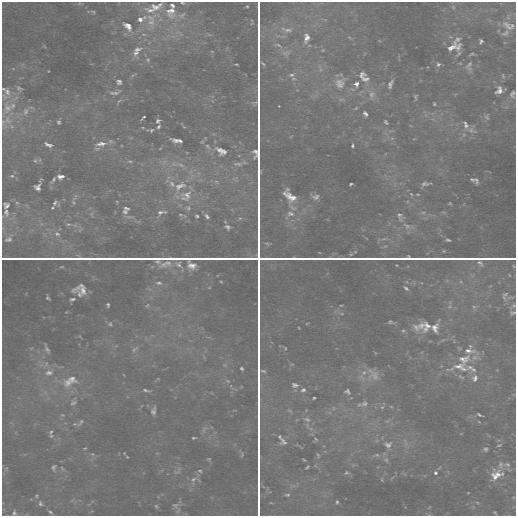

In [16]:
# Create grid of generated samples and show it

n_samples = 4
samples = show_grid_samples(
    n_samples, diffusion, model, image_size, channels, "grid_substrates"
)

In [11]:
# Generate many new separate samples and save them

generate_and_save_samples(sample_dir, 30, 10, diffusion, model, image_size, channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [17]:
# Count FID metric

feature = 2048
print(
    f"feature = {feature}, FID =",
    count_fid_metric(
        train_loader, diffusion, model, image_size, channels, 200, feature
    ),
)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

210 samples are generated, time = 239.990 sec
FID is computed, time = 18.121 sec
feature = 2048, FID = tensor(138.4779)
